In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
import pickle
%matplotlib inline

import sys
sys.path.append("../")

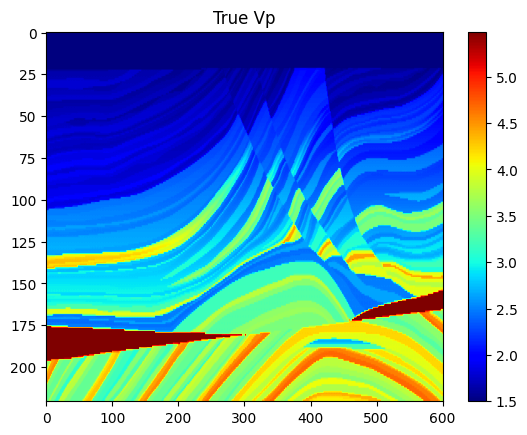

In [2]:
device=torch.device('cuda')

# Medium dimensions
nx=601
dx=0.015
nz=221
dz=0.015

# Sources
n_sources_per_shot=1
n_shots=30
d_source=0.3/dx
first_source=0
source_depth=0

# Receivers
n_receivers_per_shot=125
d_receiver=0.06/dx
first_receiver=0
receiver_depth=0

# Recording time
nt=4000
dt=0.001
ot=0
freq=4
peak_time=1/freq
fs=1/dt


# Source_locations
source_locations=torch.zeros(n_shots, n_sources_per_shot, 2,
                               dtype=torch.long, device=device)
source_locations[..., 1]=source_depth
source_locations[:, 0, 0]=(torch.arange(n_shots) * d_source +
                             first_source)

# Receiver_locations
receiver_locations=torch.zeros(n_shots, n_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
receiver_locations[..., 1]=receiver_depth
receiver_locations[:, :, 0]=(
    (torch.arange(n_receivers_per_shot) * d_receiver +
     first_receiver)
    .repeat(n_shots, 1)
)

# Source_amplitudes
source_amplitudes=(
    (deepwave.wavelets.ricker(freq, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1).to(device)
)

# Load the true model
v_true=torch.from_numpy(np.fromfile('marmousi.bin', np.float32).reshape(nz, nx)).T.to(device)
m_vmin, m_vmax=np.percentile(v_true.cpu().numpy(), [2,98]) 

plt.figure()
plt.imshow(v_true.T.cpu().numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet', aspect='auto')
plt.colorbar()
plt.title('True Vp');



# function to get water layer mask
def mask(m,value):
    """
    Return a mask for the model (m) using the (value)
    """
    msk = m > value
    msk = msk.to(torch.int) 
    return msk


# Load the true model
model_true = v_true

water_threshold=torch.tensor([1.5]).to(model_true.device)
msk = mask(model_true, water_threshold) # get the mask for the water layer 

# model_true = torch.Tensor(model_true) 
msk = torch.Tensor(msk)
# msk = msk.to(v.device)

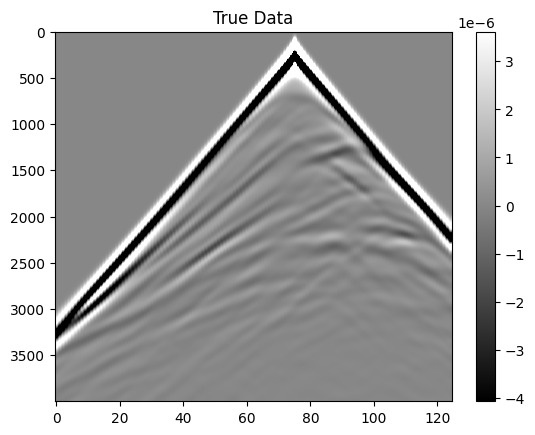

In [3]:
# Generate data
observed_data=deepwave.scalar(
    v_true, [dz,dx], dt,
    source_amplitudes=source_amplitudes,
    source_locations=source_locations,
    receiver_locations=receiver_locations,
    pml_freq=freq,
)
d_vmin, d_vmax=np.percentile(observed_data[-1].cpu().numpy(), [2,98]) 

plt.figure()
plt.imshow(observed_data[-1][n_shots//2].T.detach().cpu().numpy(), vmin=d_vmin, vmax=d_vmax, cmap='gray', aspect='auto')
plt.colorbar()
plt.title('True Data');

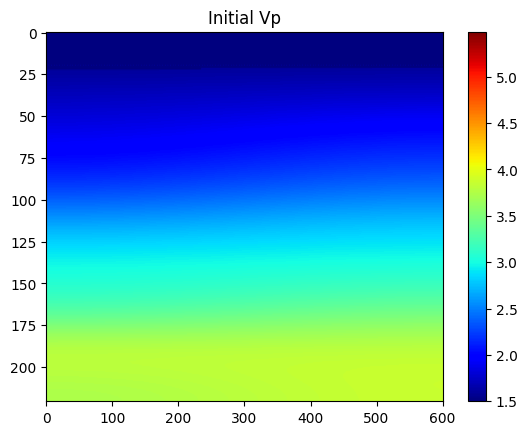

In [4]:
# Create initial velocity model
v_init=(torch.tensor(1/gaussian_filter(1/v_true.detach().cpu().numpy(), [300,15])).to(device))
v_init=v_init*msk
v_init[v_init==0] = 1.5
v=v_init.clone().requires_grad_(True)


plt.figure()
plt.imshow(v_init.T.cpu().numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet', aspect='auto')
plt.colorbar()
plt.title('Initial Vp');

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.nn.init as init

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 148 * 53, 128)
        self.dropout1 = nn.Dropout(0.3)  # Use separate dropout instances
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 601 * 221)

        # Initialize weights using Xavier initialization
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0.0)





    def forward(self, xinp):
        x = self.pool(F.relu(self.conv1(xinp)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 148 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x).view(-1, 1, 601, 221)
        # # Calculate the scaling factor
        # scaling_factor = torch.norm(xinp) / torch.norm(x)
        
        # # Scale the smoothed gradient
        # x = x*scaling_factor
        return x #+ xinp



# Create an instance of the CNN model
model = ConvNet()
model = model.to(device)

In [8]:
# Set seed for reproducibility
torch.manual_seed(42)

# Initialize your UNet model
# model = UNet(1, 1, hidden_channels=16).to(device)

# Load pre-trained weights
# pretrained_weights_path = 'cnn_model_final_final_unnorm.pth'
pretrained_weights_path = 'cnn_model_final_final_unnorm_test4hz.pth'
pretrained_dict = torch.load(pretrained_weights_path)

# Filter out unnecessary keys from the pretrained weights
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# Update the model weights with the pre-trained weights
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

# Apply weight initialization
# model.apply(weights_init)

<All keys matched successfully>

0.001084028586774366


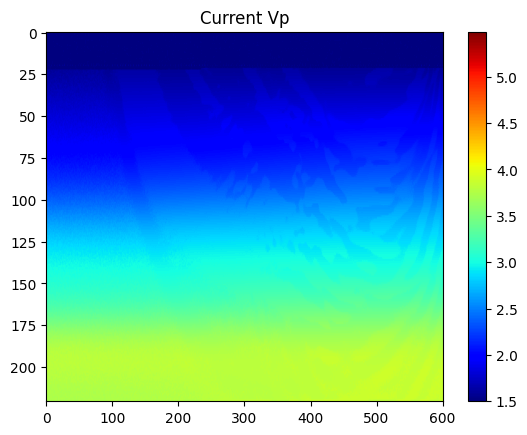

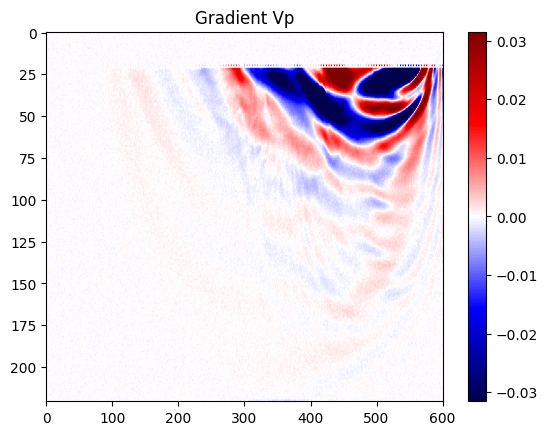

0.002660475016455166


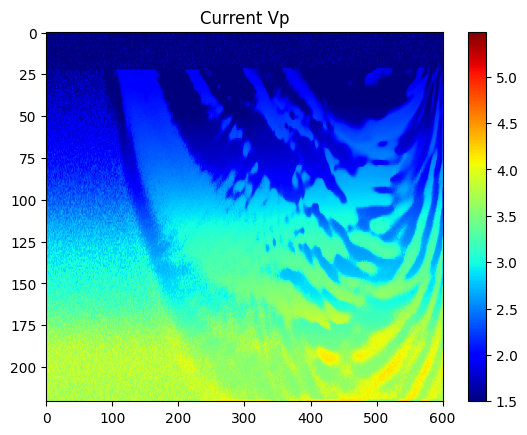

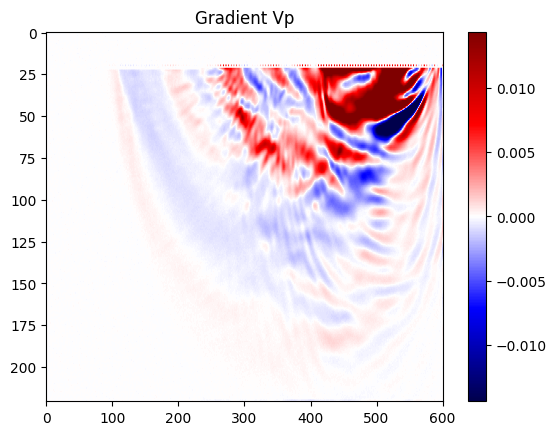

0.005081291310489178


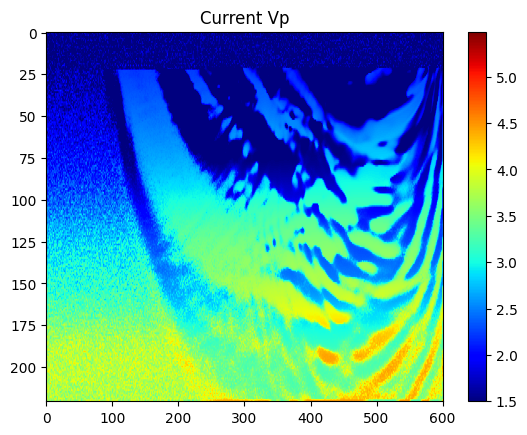

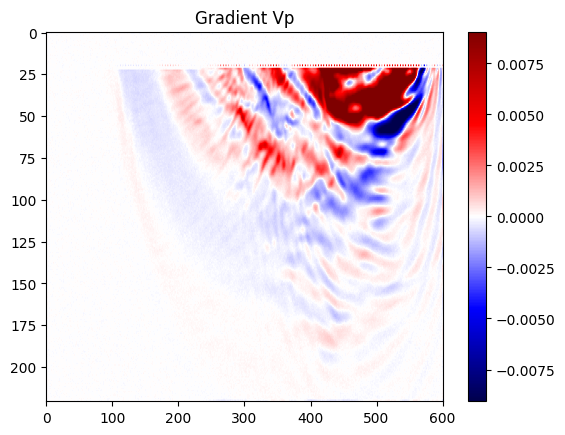

0.007574303017463535


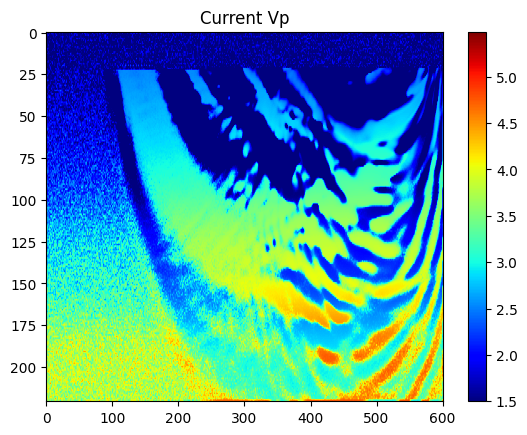

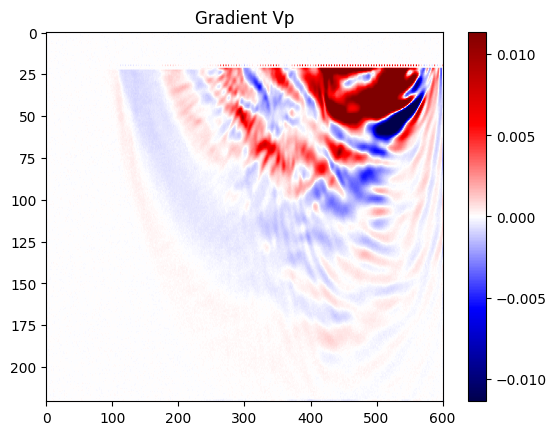

0.008684600325068459


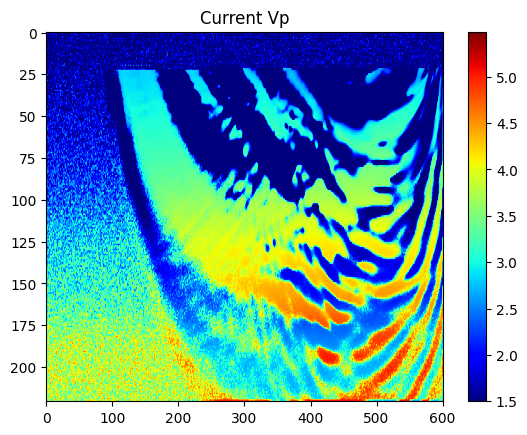

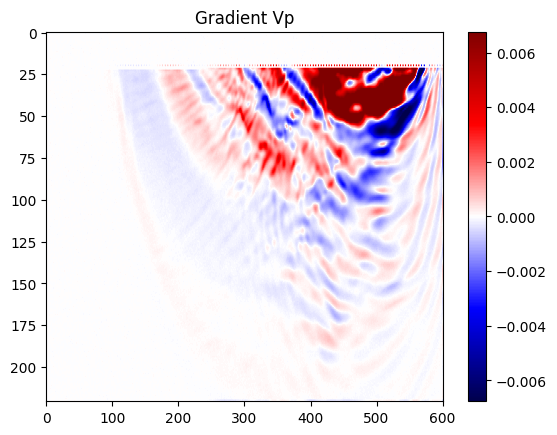

0.009593669696187135


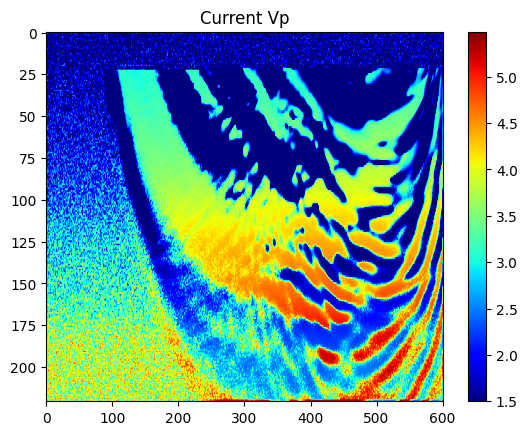

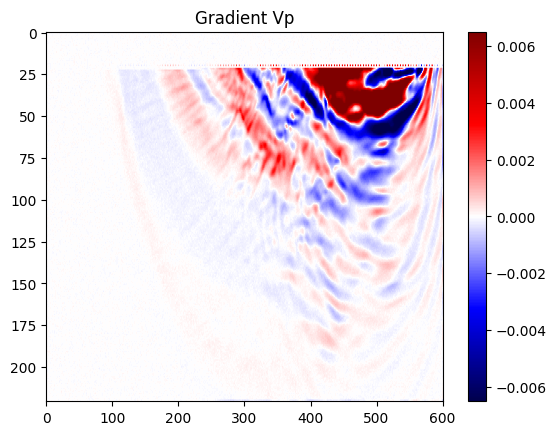

0.009538483660435304


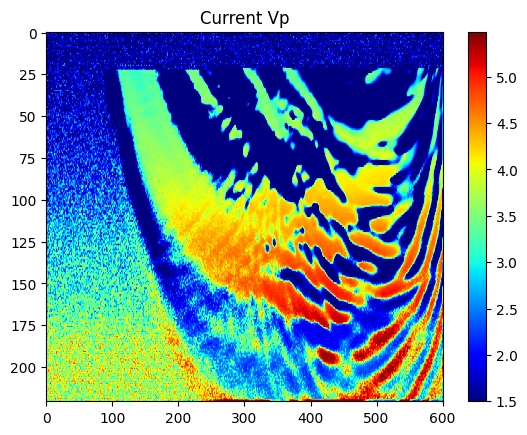

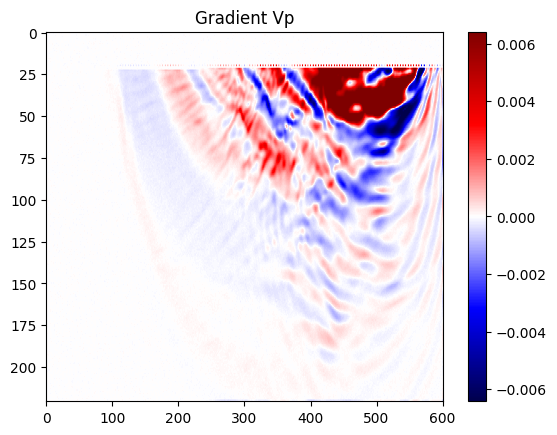

0.009650058178522158


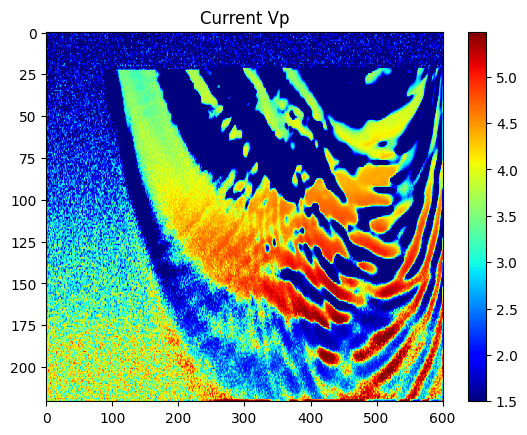

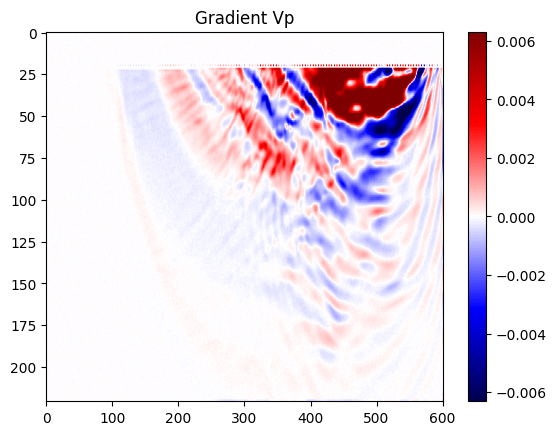

0.009757536805409472


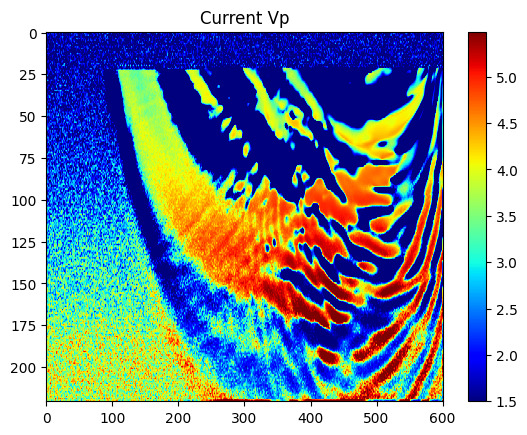

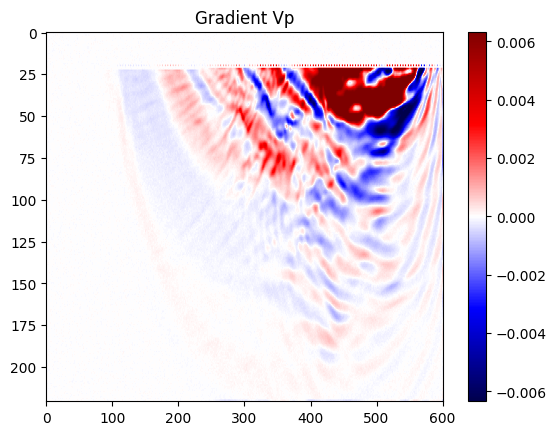

0.00986614004796138


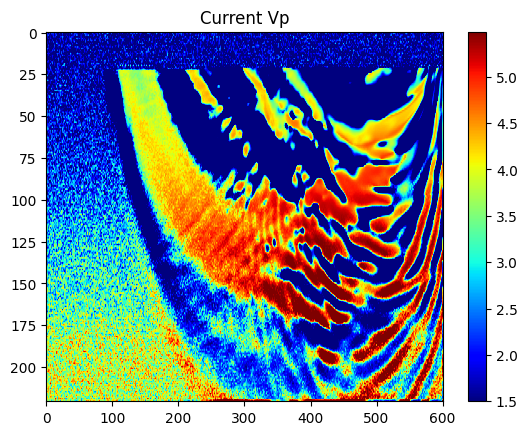

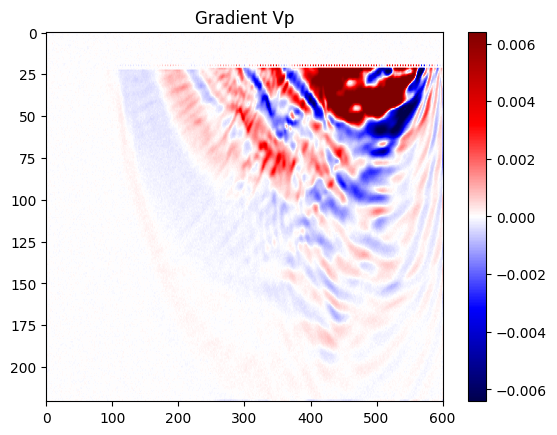

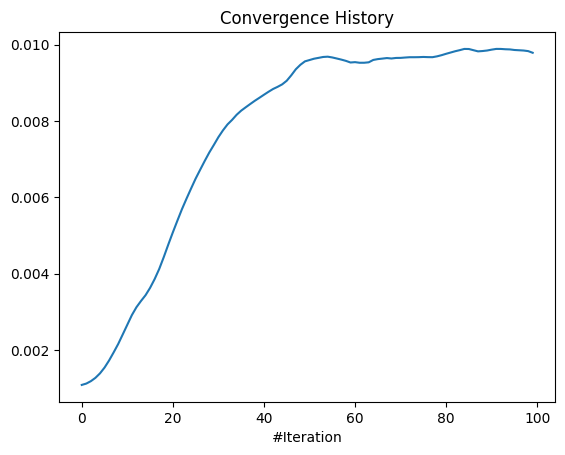

In [13]:
#Applying 2 optimizations using pretrained network
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
max_grad_value = None
original_grads = None


# Setup optimiser to perform inversion vmin=-1.0,vmax=1.0,
optimiser = torch.optim.Adam([v], lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()
criterion = nn.MSELoss()

# Run optimisation/inversion
n_iterations = 100
n_batches = 1
updates = []
gradients = []

observed_data = observed_data[-1]
scaler = observed_data.abs().max()
observed_data=observed_data/scaler
epoch_loss = []

for epoch in range(n_iterations):
    running_loss = 0

    # Perform computation per batch
    for it in range(0, n_shots, n_batches):
        optimiser.zero_grad()
        optimizer.zero_grad()
        out = deepwave.scalar(
            v, dx, dt,
            source_amplitudes=source_amplitudes[it:it+n_batches, :, :],
            source_locations=source_locations[it:it+n_batches, :, :],
            receiver_locations=receiver_locations[it:it+n_batches, :, :],
            pml_freq=freq,
        )
        loss = loss_fn(out[-1]/scaler, observed_data[it:it+n_batches, :, :])
        loss.backward()

        # Normalize gradients
        if epoch == 0 and max_grad_value is None:
            max_grad_value = v.grad.abs().max()
        v.grad /= max_grad_value
        
        # Apply mask to gradients
        v.grad *= msk

        


        
        
        

        original_grads = v.grad.detach().clone()
        c = original_grads.unsqueeze(0).unsqueeze(0)


        # Smooth the gradients using the pre-trained UNet model
        # if epoch % 10 == 0 :
        model.train()
        # valid_loss = 0.0
        # with torch.no_grad():
        smoothed_gradients = model(c.to(device))
        smoothed_gradients = smoothed_gradients.squeeze(0).squeeze(0)
        

        

        # # Calculate the scaling factor
        # scaling_factor = torch.norm(v.grad) / torch.norm(smoothed_gradients)
        
        # # Scale the smoothed gradient
        # smoothed_gradients *= scaling_factor

                # Calculate the minimum and maximum values of the original gradients
     

        

        v.grad = smoothed_gradients


        torch.nn.utils.clip_grad_value_(
            v,
            torch.quantile(v.grad.detach().abs(), 0.98)
        )        

        #Two optimizers
        
        optimiser.step()

        #if epoch != 0:
        optimizer.step()
        running_loss += loss.item()
        

    epoch_loss.append(running_loss)

    
    

    # Plotting every 25 iterations
    if epoch % 10 == 0:
        print(running_loss)
        plt.figure()
        plt.imshow(v.T.cpu().detach().numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet', aspect='auto')
        plt.colorbar()
        plt.title('Current Vp');
        plt.show()

        plt.figure()
        plt.imshow(v.grad.T.cpu().detach().numpy(), cmap='seismic', aspect='auto')
        plt.colorbar()
        plt.title('Gradient Vp');
        plt.show()


    

# Plot convergence
plt.figure()
plt.plot(np.arange(n_iterations), np.array(epoch_loss))
plt.xlabel('#Iteration')
plt.title('Convergence History');

